In [3]:
from IPython.display import Image, display

In [2]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/1.png"))

NameError: name 'Image' is not defined

A primary function of data cleaning is to verify all data is in the expected format. Spark provides a built-in ability to validate datasets with schemas. You may have used schemas before with databases or XML; Spark is similar. A schema defines and validates the number and types of columns for a given DataFrame. A schema can contain many different types of fields - integers, floats, dates, strings, and even arrays or mapping structures. A defined schema allows Spark to filter out data that doesn't conform during read, ensuring expected correctness. In addition, schemas also have performance benefits. Normally a data import will try to infer a schema on read - this requires reading the data twice. Defining a schema limits this to a single read operation.

Here is an example schema to the import data from our previous example. First we'll import the pyspark.sql.types library. Next we define the actual StructType list of StructFields, containing an entry for each field in the data. Each StructField consists of a field name, dataType, and whether the data can be null. Once our schema is defined, we can add it into our spark.read.format.load call and process it against our data. The load() method takes two arguments - the filename and a schema. This is where we apply our schema to the data being loaded.

# Immutability 

Normally in Python, and most other languages, variables are fully mutable. The values can be changed at any given time, assuming the scope of the variable is valid. While very flexible, this does present problems anytime there are multiple concurrent components trying to modify the same data. Most languages work around these issues using constructs like mutexes, semaphores, etc. This can add complexity, especially with non-trivial programs.

Unlike typical Python variables, Spark Data Frames are immutable. While not strictly required, immutability is often a component of functional programming. We won't go into everything that implies here, but understand that Spark is designed to use immutable objects. Practically, this means Spark Data Frames are defined once and are not modifiable after initialization. If the variable name is reused, the original data is removed (assuming it's not in use elsewhere) and the variable name is reassigned to the new data. While this seems inefficient, it actually allows Spark to share data between all cluster components. It can do so without worry about concurrent data objects.

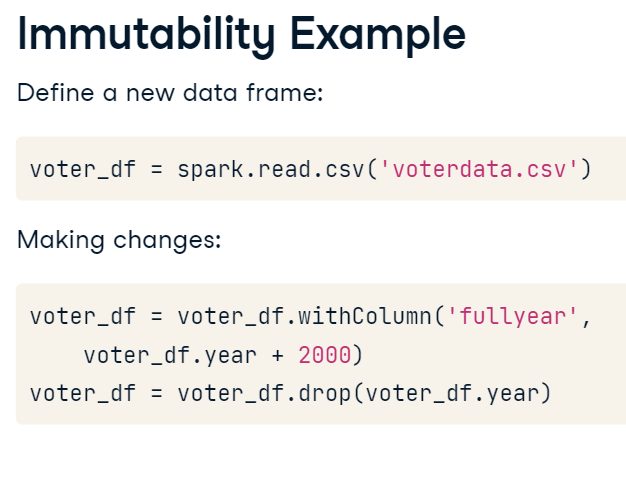

In [3]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/2.png"))

This is a quick example of the immutability of data frames in Spark. It's OK if you don't understand the actual code, this example is more about the concepts of what happens. First, we create a data frame from a CSV file called voterdata.csv. This creates a new data frame definition and assigns it to the variable name voter_df. Once created, we want to do two further operations. The first is to create a fullyear column by using a 2-digit year present in the data set and adding 2000 to each entry. This does not actually change the data frame at all. It copies the original definition, adds the transformation, and assigns it to the voter_df variable name. Our second operation is similar - now we want to drop the original year column from the data frame. Again, this copies the definition, adds a transformation and reassigns the variable name to this new object. The original objects are destroyed. Please note that the original year column is now permanently gone from this instance, though not from the underlying data (ie, you could simply reload it to a new dataframe if desired).

# Lazy Processing

You may be wondering how Spark does this so quickly, especially on large data sets. Spark can do this because of something called lazy processing. Lazy processing in Spark is the idea that very little actually happens until an action is performed. In our previous example, we read a CSV file, added a new column, and deleted another. The trick is that no data was actually read / added / modified, we only updated the instructions (aka, Transformations) for what we wanted Spark to do. This functionality allows Spark to perform the most efficient set of operations to get the desired result. 

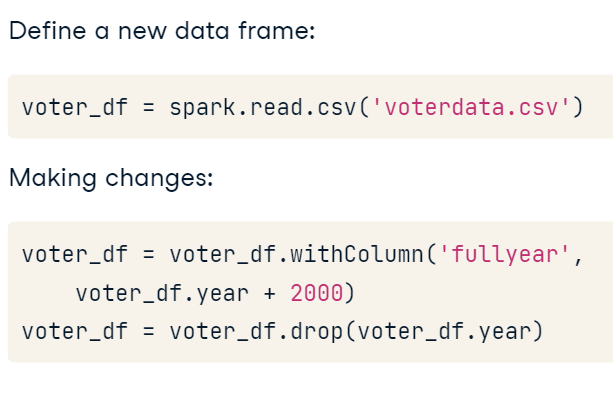

In [4]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/3.png"))

The code example is the same as the previous slide, but with the added count() method call. This classifies as an action in Spark and will process all the transformation operations.

## Example: Using Lazy Processing

Lazy processing operations will usually return in about the same amount of time regardless of the actual quantity of data. Remember that this is due to Spark not performing any transformations until an action is requested.

For this exercise, we'll be defining a Data Frame (aa_dfw_df) and add a couple transformations. Note the amount of time required for the transformations to complete when defined vs when the data is actually queried. These differences may be short, but they will be noticeable. When working with a full Spark cluster with larger quantities of data the difference will be more apparent.

In [ ]:
# Load the CSV file
aa_dfw_df = spark.read.format('csv').options(Header=True).load('AA_DFW_2018.csv.gz')

# Add the airport column using the F.lower() method
aa_dfw_df = aa_dfw_df.withColumn('airport', F.lower(aa_dfw_df['Destination Airport']))

# Drop the Destination Airport column
aa_dfw_df = aa_dfw_df.drop(aa_dfw_df['Destination Airport'])

# Show the DataFrame
aa_dfw_df.show()


# Understanding Parquet

## Difficulties with CSV files

As we've seen, Spark can read in text and CSV files. While this gives us access to many data sources, it's not always the most convenient format to work with. Let's take a look at a few problems with CSV files.

Some common issues with CSV files include: The schema is not defined: there are no data types included, nor column names (beyond a header row). Using content containing a comma (or another delimiter) requires escaping. Using the escape character within content requires even further escaping. The available encoding formats are limited depending on the language used.

### Spark and CSV files

In addition to the issues with CSV files in general, Spark has some specific problems processing CSV data. CSV files are quite slow to import and parse. The files cannot be shared between workers during the import process. If no schema is defined, all data must be read before a schema can be inferred. Spark has feature known as predicate pushdown. Basically, this is the idea of ordering tasks to do the least amount of work. Filtering data prior to processing is one of the primary optimizations of predicate pushdown. This drastically reduces the amount of information that must be processed in large data sets. Unfortunately, you cannot filter the CSV data via predicate pushdown. Finally, Spark processes are often multi-step and may utilize an intermediate file representation. These representations allow data to be used later without regenerating the data from source. Using CSV would instead require a significant amount of extra work defining schemas, encoding formats, etc.

## The Parquet Format

Parquet is a compressed columnar data format developed for use in any Hadoop based system. This includes Spark, Hadoop, Apache Impala, and so forth. The Parquet format is structured with data accessible in chunks, allowing efficient read / write operations without processing the entire file. This structured format supports Spark's predicate pushdown functionality, providing significant performance improvement. Finally, Parquet files automatically include schema information and handle data encoding. This is perfect for intermediary or on-disk representation of processed data. Note that Parquet files are a binary file format and can only be used with the proper tools. This is in contrast to CSV files which can be edited with any text editor.

## Working with Parquet

Interacting with Parquet files is very straightforward. To read a parquet file into a Data Frame, you have two options. The first is using the `spark.read.format` method we've seen previously. The Data Frame, df=spark.read.format('parquet').load('filename.parquet') The second option is the shortcut version: The Data Frame, df=spark.read.parquet('filename.parquet') Typically, the shortcut version is the easiest to use but you can use them interchangeably. Writing parquet files is similar, using either: df.write.format('parquet').save('filename.parquet') or df.write.parquet('filename.parquet') The long-form versions of each permit extra option flags, such as when overwriting an existing parquet file.

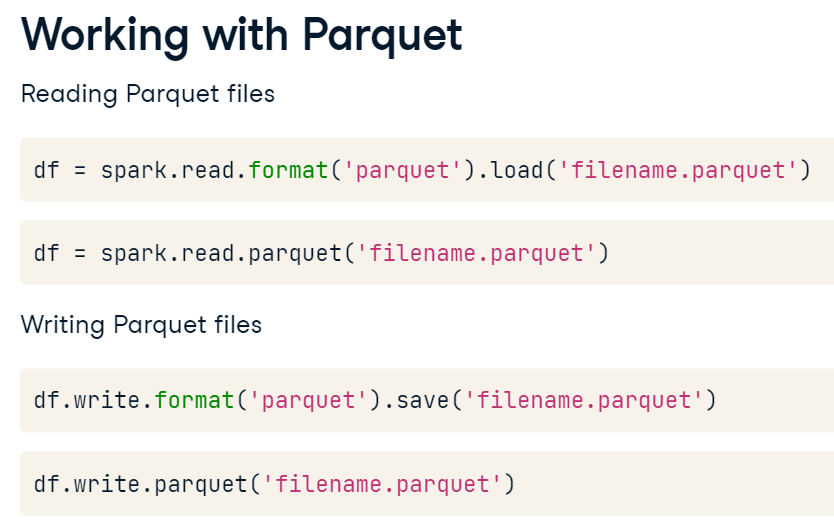

In [5]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/4.png"))

## Parquet and SQL

Parquet files have various uses within Spark. We've discussed using them as an intermediate data format, but they also are perfect for performing SQL operations. To perform a SQL query against a Parquet file, we first need to create a Data Frame via the spark.read.parquet method. Once we have the Data Frame, we can use the createOrReplaceTempView() method to add an alias of the Parquet data as a SQL table. Finally, we run our query using normal SQL syntax and the spark.sql method. In this case, we're looking for all flights with a duration under 100 minutes. Because we're using Parquet as the backing store, we get all the performance benefits we've discussed previously (primarily defined schemas and the available use of predicate pushdown).

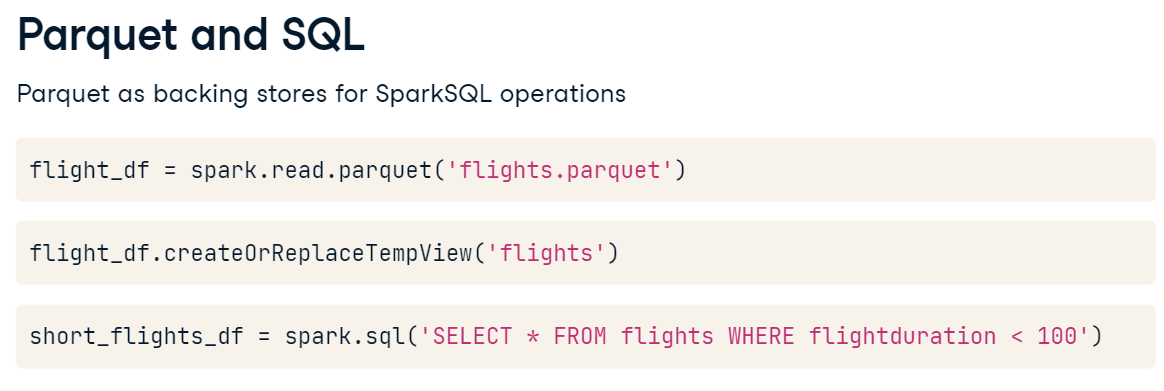

In [6]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/5.png"))

### Example

Parquet files are perfect as a backing data store for SQL queries in Spark. While it is possible to run the same queries directly via Spark's Python functions, sometimes it's easier to run SQL queries alongside the Python options.

For this example, we're going to read in the Parquet file we created in the last exercise and register it as a SQL table. Once registered, we'll run a quick query against the table (aka, the Parquet file).

The spark object and the AA_DFW_ALL.parquet file are available for you automatically.

In [ ]:
# Read the Parquet file into flights_df
flights_df = spark.read.parquet('AA_DFW_ALL.parquet')

# Register the temp table
flights_df.createOrReplaceTempView('flights')

# Run a SQL query of the average flight duration
avg_duration = spark.sql('SELECT avg(flight_duration) from flights').collect()[0]
print('The average flight time is: %d' % avg_duration)

## Saving a DataFrame in Parquet format

In [ ]:
# View the row count of df1 and df2
print("df1 Count: %d" % df1.count())
print("df2 Count: %d" % df2.count())

# Combine the DataFrames into one
df3 = df1.union(df2)

# Save the df3 DataFrame in Parquet format
df3.write.parquet('AA_DFW_ALL.parquet', mode='overwrite')

# Read the Parquet file into a new DataFrame and run a count
print(spark.read.parquet('AA_DFW_ALL.parquet').count())

# DataFrame column operations

In the first chapter, we've spent some time discussing the basics of Spark data and file handling. Let's now take a look at how to use Spark column operations to clean data.
Before we discuss manipulating DataFrames in depth, let's talk about some of their features. DataFrames are made up of rows & columns and are generally analogous to a database table. DataFrames are immutable: any change to the structure or content of the data creates a new DataFrame. DataFrames are modified through the use of transformations. 

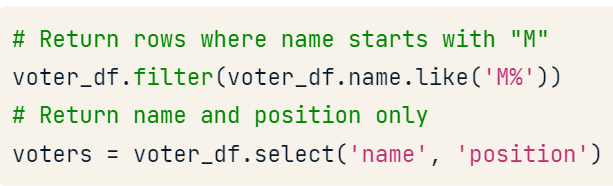

In [7]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/6.png"))

An example is The .filter() command to only return rows where the name starts with the letter 'M'. Another operation is .select(), in this case returning only the name and position fields.

## Common DataFrame Transformations

There are many different transformations for use on a DataFrame. They vary depending on what you'd like to do. Some common transformations include: 

The **.filter()** clause, which includes only rows that satisfy the requirements defined in the argument. This is analogous to the WHERE clause in SQL. Spark includes a .where() alias which you can use in place of .filter() if desired. This call returns only rows where the vote occurred after 1/1/2019. 

Another common option is the **.select()** method which returns the columns requested from the DataFrame. 

The **.withColumn()** method creates a new column in the DataFrame. The first argument is the name of the column, and the second is the command(s) to create it. In this case, we create a column called 'year' with just the year information. 

We also can use the **.drop()** method to remove a column from a DataFrame.

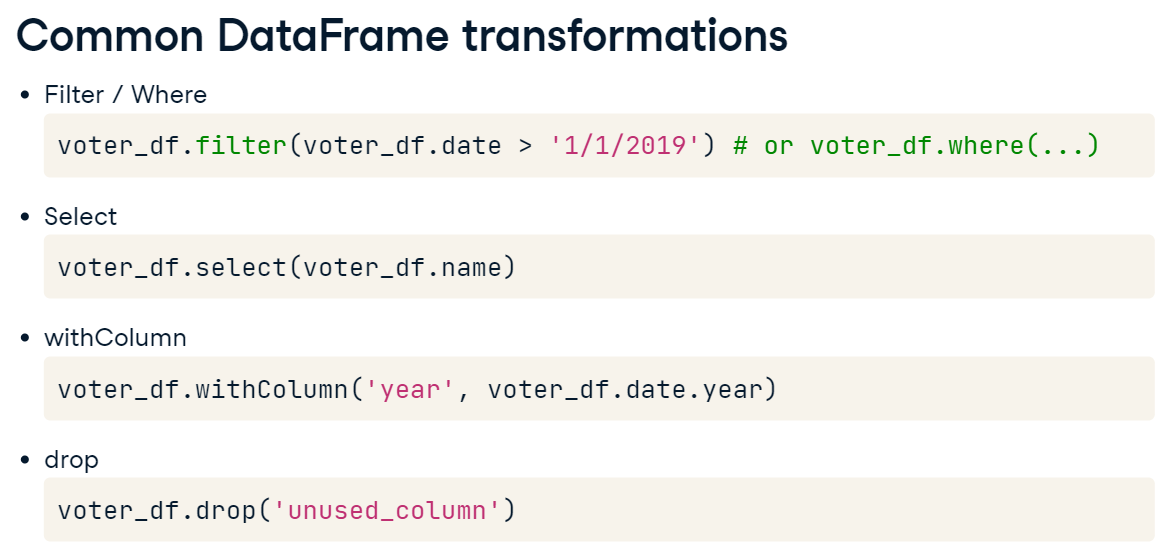

In [18]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/7.png"))

## Filtering Data

Among the most common operations used when cleaning a DataFrame, filtering lets us use only the data matching our desired result. We can use .filter() for many tasks, such as: 

- Removing null values. Removing odd entries, anything that doesn't fit our desired format. We can also split a DataFrame containing combined data (such as a syslog file). 

- As mentioned previously, use the .filter() method to return only rows that meet the specified criteria. 

- The .contains() function takes a string argument that the column must have to return true. You can negate these results using the tile (~) character.

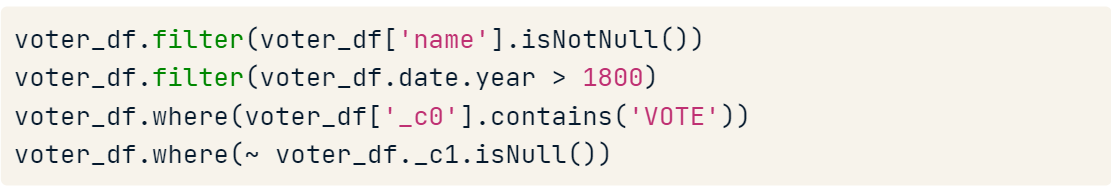

In [9]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/8.png"))

### Example 1

Filtering column content with Python
You've looked at using various operations on DataFrame columns - now you can modify a real dataset. The DataFrame voter_df contains information regarding the voters on the Dallas City Council from the past few years. This truncated DataFrame contains the date of the vote being cast and the name and position of the voter. Your manager has asked you to clean this data so it can later be integrated into some desired reports. The primary task is to remove any null entries or odd characters and return a specific set of voters where you can validate their information.

This is often one of the first steps in data cleaning - removing anything that is obviously outside the format. For this dataset, make sure to look at the original data and see what looks out of place for the VOTER_NAME column.

The pyspark.sql.functions library is already imported under the alias F.

In [11]:
# Show the distinct VOTER_NAME entries
voter_df.select('VOTER_NAME').distinct().show(40, truncate=False)

# Filter voter_df where the VOTER_NAME is 1-20 characters in length
voter_df = voter_df.filter('length(VOTER_NAME) > 0 and length(VOTER_NAME) < 20')

# Filter out voter_df where the VOTER_NAME contains an underscore
voter_df = voter_df.filter(~ F.col('VOTER_NAME').contains('_'))

# Show the distinct VOTER_NAME entries again
voter_df.select('VOTER_NAME').distinct().show(40, truncate=False)

NameError: name 'voter_df' is not defined

### Example 2

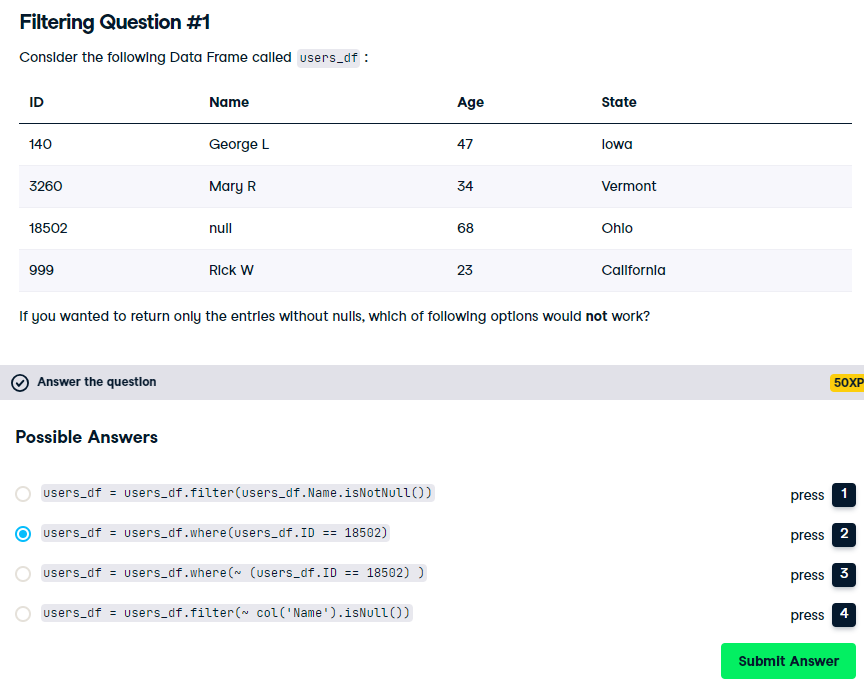

In [12]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/11.png"))

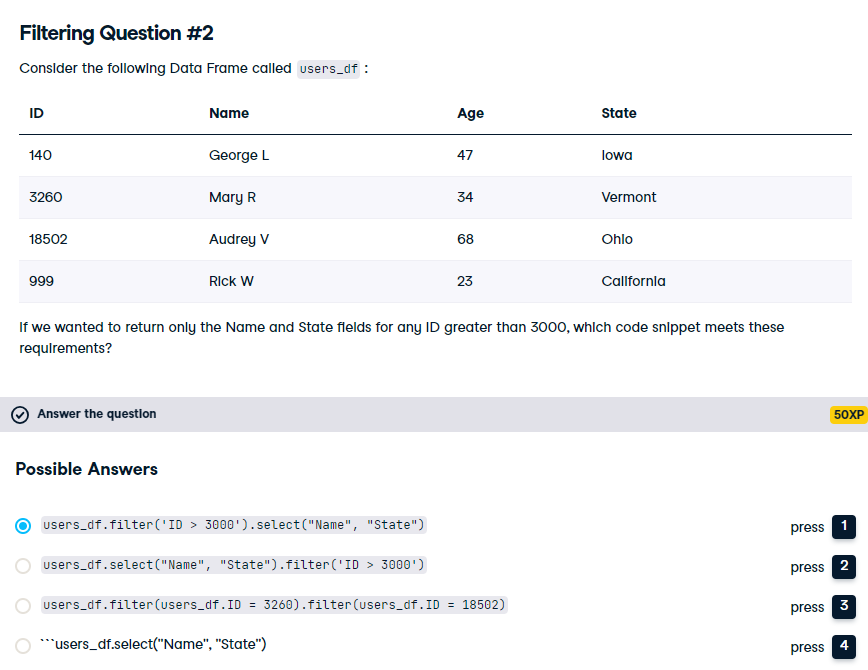

In [13]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/12.png"))

On first glance, either of the first two answers appear like they would work. If the .select() transformation is run first, there is not an ID column present to filter on. These types of errors are easy to miss when running Spark tasks.

## Column String Transformations

Some of the most common operations used in data cleaning are modifying and converting strings. You will typically apply these to each column as a transformation. Many of these functions are in the pyspark.sql.functions library. For brevity, we'll import it as the alias 'F'. We use the .withColumn() function to create a new column called "upper" using pyspark.sql.functions.upper() on the name column. The "upper" column will contain uppercase versions of all names. We can create intermediary columns that are only for processing. This is useful to clarify complex transformations requiring multiple steps. In this instance, we call the .split() function with the name of the column and the space character to split on. This returns a list of words in a column called splits. A very common operation is converting string data to a different type, such as converting a string column to an integer. We use the .cast() function to perform the conversion to an IntegerType().

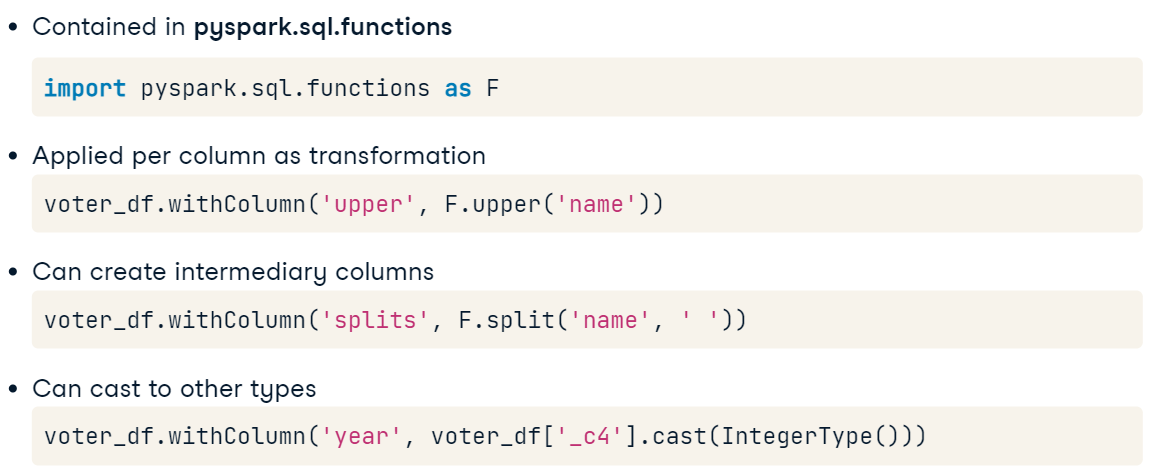

In [19]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/9.png"))

## ArrayType() column functions

While performing data cleaning with Spark, you may need to interact with ArrayType() columns. These are analogous to lists in normal python environments. One function we will use is .size(), which returns the number of items present in the specified ArrayType() argument. Another commonly used function for ArrayTypes is .getItem(). It takes an index argument and returns the item present at that index in the list column. Spark has many more transformations and utility functions available. When using Spark in production, make sure to reference the documentation for available options.

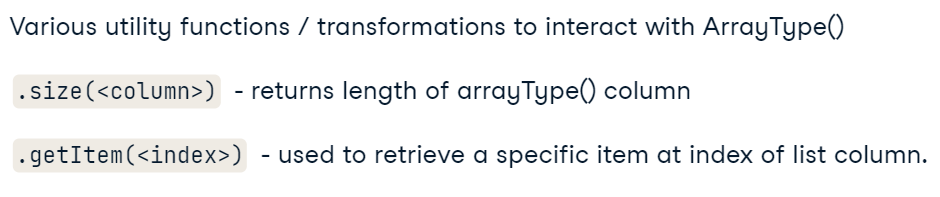

In [10]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/10.png"))

### Example: Modifying DataFrame columns

Previously, you filtered out any rows that didn't conform to something generally resembling a name. Now based on your earlier work, your manager has asked you to create two new columns - first_name and last_name. She asks you to split the VOTER_NAME column into words on any space character. You'll treat the last word as the last_name, and all other words as the first_name. You'll be using some new functions in this exercise including .split(), .size(), and .getItem(). The .getItem(index) takes an integer value to return the appropriately numbered item in the column. The functions .split() and .size() are in the pyspark.sql.functions library.

Please note that these operations are always somewhat specific to the use case. Having your data conform to a format often matters more than the specific details of the format. Rarely is a data cleaning task meant just for one person - matching a defined format allows for easier sharing of the data later (ie, Paul doesn't need to worry about names - Mary already cleaned the dataset).

The filtered voter DataFrame from your previous exercise is available as voter_df. The pyspark.sql.functions library is available under the alias F.

In [ ]:
# Add a new column called splits separated on whitespace
voter_df = voter_df.withColumn('splits', F.split(voter_df.VOTER_NAME, '\s+'))

# Create a new column called first_name based on the first item in splits
voter_df = voter_df.withColumn('first_name', voter_df.splits.getItem(0))

# Get the last entry of the splits list and create a column called last_name
voter_df = voter_df.withColumn('last_name', voter_df.splits.getItem(F.size('splits') - 1))

# Drop the splits column
voter_df = voter_df.drop('splits')

# Show the voter_df DataFrame
voter_df.show()

# Conditional DataFrame column operations

We've looked at some of the power available when using Spark's functions to filter and modify our Data Frames. Let's spend some time with some more advanced options.

## Conditional clauses

The DataFrame transformations we've covered thus far are blanket transformations, meaning they're applied regardless of the data. Often you'll want to conditionally change some aspect of the contents. Spark provides some built in conditional clauses which act similar to an if / then / else statement in a traditional programming environment. While it is possible to perform a traditional if / then / else style statement in Spark, it can lead to serious performance degradation as each row of a DataFrame would be evaluated independently. Using the optimized, built-in conditionals alleviates this. There are two components to the conditional clauses: .when(), and the optional .otherwise(). Let's look at them in more depth.

## Conditional example

The .when() clause is a method available from the pyspark.sql.functions library that is looking for two components: the if condition, and what to do if it evaluates to true. This is best seen from an example. Consider a DataFrame with the Name and Age columns. We can actually add an extra argument to our .select() method using the .when() clause. We select df.Name and df.Age as usual. For the third argument, we'll define a when conditional. If the Age column is 18 or up, we'll add the string "Adult". If the clause doesn't match, nothing is returned. Note that our returned DataFrame contains an unnamed column we didn't define using .withColumn(). The .select() function can create columns dynamically based on the arguments provided. Let's look at some more examples.

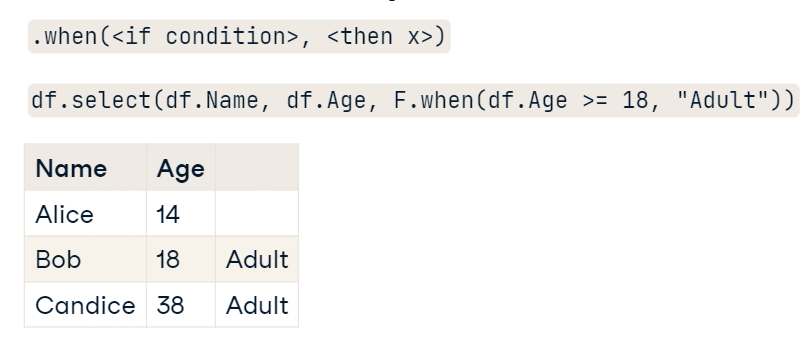

In [14]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/13.png"))

## Another example

You can chain multiple when statements together, similar to an if / else if structure. In this case, we define two .when() clauses and return Adult or Minor based on the Age column. You can chain as many when clauses together as required.

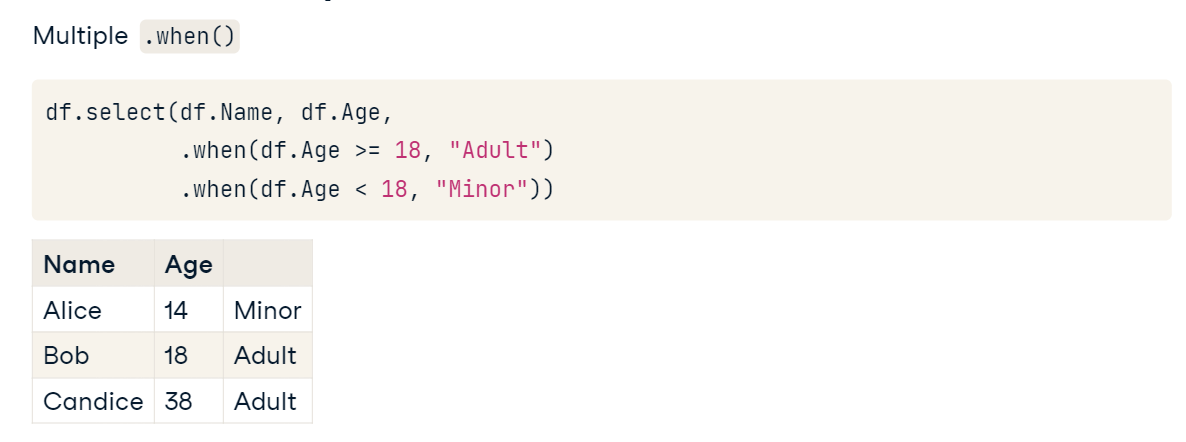

In [15]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/14.png"))

## Otherwise

In addition to .when() is the otherwise() clause. .otherwise() is analogous to the else statement. It takes a single argument, which is what to return, in case the when clause or clauses do not evaluate as True. In this example, we return "Adult" when the Age column is 18 or higher. Otherwise, we return "Minor". The resulting DataFrame is the same, but the method is different. While you can have multiple .when() statements chained together, you can only have a single .otherwise() per .when() chain.

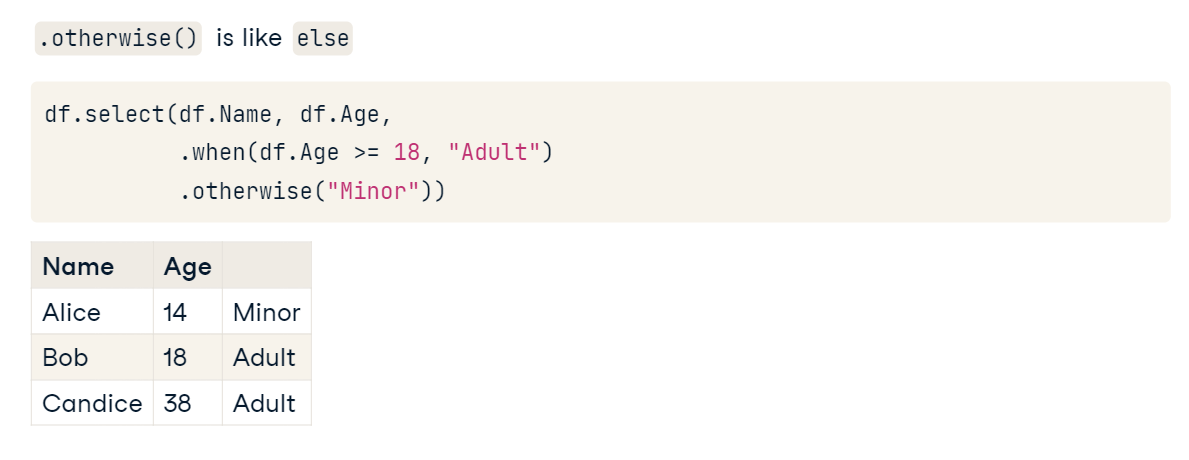

In [16]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/15.png"))

## when() example

In [ ]:
# Add a column to voter_df for any voter with the title **Councilmember**
voter_df = voter_df.withColumn('random_val',
                               when(voter_df.TITLE=='Councilmember',F.rand()))

# Show some of the DataFrame rows, noting whether the when clause worked
voter_df.show()

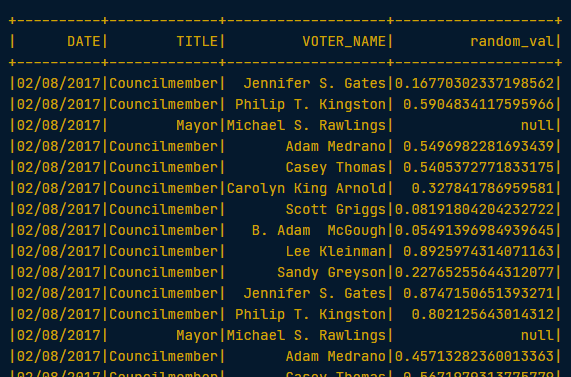

In [17]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/16.png"))

## When/ Otherwise example

In [ ]:
# Add a column to voter_df for a voter based on their position
voter_df = voter_df.withColumn('random_val',
                               when(voter_df.TITLE == 'Councilmember', F.rand())
                               .when(voter_df.TITLE == 'Mayor', 2)
                               .otherwise(0)
)

# Show some of the DataFrame rows
voter_df.show()

# Use the .filter() clause with random_val
voter_df.filter(voter_df.random_val==0).show()

# User Defined Functions

A user defined function, or UDF, is a Python method that the user writes to perform a specific bit of logic. Once written, the method is called via the pyspark.sql.functions.udf() method. The result is stored as a variable and can be called as a normal Spark function. Let's look at a couple examples.

Here is a fairly trivial example to illustrate how a UDF is defined. First, we define a python function. We'll call our function, reverseString(), with an argument called mystr. We'll use some python shorthand to reverse the string and return it. Don't worry about understanding how the return statement works, only that it will reverse the lettering of whatever is fed into it (ie, "help" becomes "pleh"). The next step is to wrap the function and store it in a variable for later use. We'll use the pyspark.sql.functions.udf() method. It takes two arguments - the name of the method you just defined, and the Spark data type it will return. This can be any of the options in pyspark.sql.types, and can even be a more complex type, including a fully defined schema object. Most often, you'll return either a simple object type, or perhaps an ArrayType. We'll call udf with our new method name, and use the StringType(), then store this as udfReverseString(). Finally, we use our new UDF to add a column to the user_df DataFrame within the .withColumn() method. Note that we pass the column we're interested in as the argument to udfReverseString(). The udf function is called for each row of the Data Frame. Under the hood, the udf function takes the value stored for the specified column (per row) and passes it to the python method. The result is fed back to the resulting DataFrame.

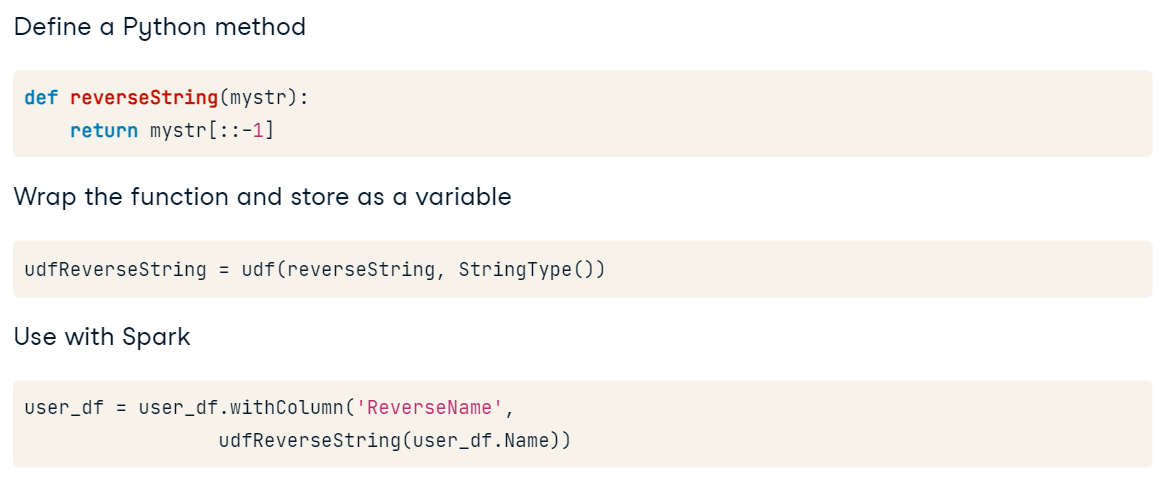

In [3]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/17.png"))

Another quick example is using a function that does not require an argument. We're defining our sortingCap() function to return one of the letters 'G', 'H', 'R', or 'S' at random. We still create our udf wrapped function, and define the return type as StringType(). The primary difference is calling the function, this time without passing in an argument as it is not required.

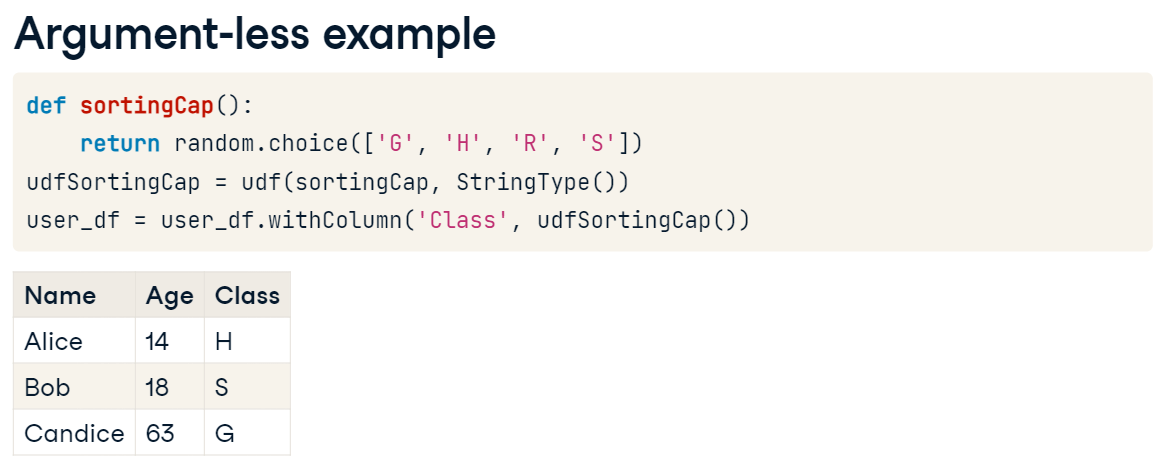

In [4]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/18.png"))

In [ ]:
# Another example

def getFirstAndMiddle(names):
  # Return a space separated string of names, except the last entry in the names list.
  return ' '.join(names[:-1])

# Define the method as a UDF
udfFirstAndMiddle = F.udf(getFirstAndMiddle,StringType())

# Create a new column using your UDF
voter_df = voter_df.withColumn('first_and_middle_name', udfFirstAndMiddle(voter_df.splits))

# Show the DataFrame
voter_df.show()

# Partitioning and lazy processing

We've discussed various transformations and methods to modify our data, but we haven't covered much about how Spark actually processes the data. Let's look at that now.

Spark breaks DataFrames into partitions, or chunks of data. These partitions can be automatically defined, enlarged, shrunk, and can differ greatly based on the type of Spark cluster being used. The size of the partition does vary, but generally try to keep your partition sizes equal. We'll discuss more about optimizing partitioning and cluster details later on. For now, let's assume that each partition is handled independently. This is part of what provides the performance levels and horizontal scaling ability in Spark. If a Spark node doesn't need to compete for resources, nor consult with other Spark nodes for answers, it can reliably schedule the processing for the best performance.

In Spark, any transformation operation is lazy; it's more like a recipe than a command. It defines what should be done to a DataFrame rather than actually doing it. Most operations in Spark are actually transformations, including .withColumn(), .select(), .filter(), and so forth. The set of transformations you define are only executed when you run a Spark action. This includes .count(), .write(), etc - anything that requires the transformations to be run to properly obtain an answer. Spark can reorder transformations for the best performance. Usually this isn't noticeable, but can occasionally cause unexpected behavior, such as IDs not being added until after other transformations have completed. This doesn't actually cause a problem but the data can look unusual if you don't know what to expect.

Relational databases tend to have a field used to identify the row, whether it is for an actual relationship reference, or just for data identification. These IDs are typically an integer that increases in value, is sequential, and most importantly unique. The problem with these IDs is they're not very parallel in nature. Given that the values are given out sequentially, if there are multiple workers, they must all refer to a common source for the next entry. This is OK in a single server environment, but in a distributed platform such as Spark, it creates some undue bottlenecks. Let's take a look at how to generate ID's in Spark.

Spark has a built-in function called monotonically_increasing_id(), designed to provide an integer ID that increases in value and is unique. These IDs are not necessarily sequential - there can be gaps, often quite large, between values. Unlike a normal relational ID, Spark's is completely parallel - each partition is allocated up to 8 billion IDs that can be assigned. Notice that the ID fields in the sample table are integers, increasing in value, but are not sequential. It's a little out scope, but the IDs are a 64-bit number effectively split into groups based on the Spark partition. Each group contains 8.4 billion IDs, and there are 2.1 billion possible groups, none of which overlap.

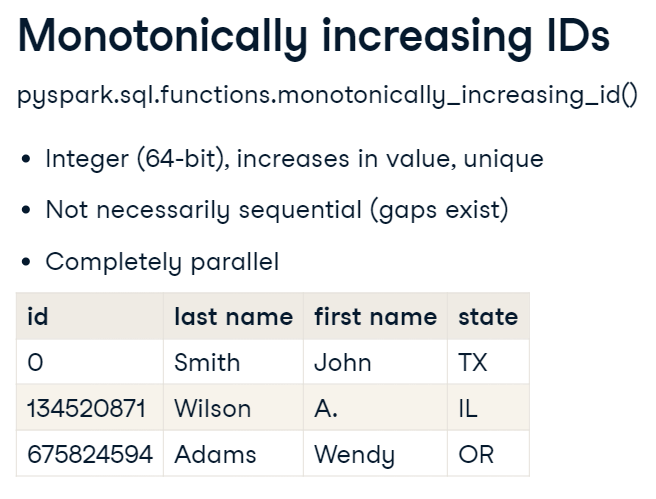

In [3]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/19.png"))

There's a lot of nuance to how partitions and the monotonically increasing ID's work. Remembering that Spark is lazy: it often helps in troubleshooting what can happen. Operations are often out of order - especially if joins are involved. It's best to test your transformations.

### Ex: Adding an ID Field

When working with data, you sometimes only want to access certain fields and perform various operations. In this case, find all the unique voter names from the DataFrame and add a unique ID number. Remember that Spark IDs are assigned based on the DataFrame partition - as such the ID values may be much greater than the actual number of rows in the DataFrame.

With Spark's lazy processing, the IDs are not actually generated until an action is performed and can be somewhat random depending on the size of the dataset.

The spark session and a Spark DataFrame df containing the DallasCouncilVotes.csv.gz file are available in your workspace. The pyspark.sql.functions library is available under the alias F.

In [ ]:
# Select all the unique council voters
voter_df = df.select(df["VOTER NAME"]).distinct()

# Count the rows in voter_df
print("\nThere are %d rows in the voter_df DataFrame.\n" % voter_df.count())

# Add a ROW_ID
voter_df = voter_df.withColumn('ROW_ID', F.monotonically_increasing_id())

# Show the rows with 10 highest IDs in the set
voter_df.orderBy(voter_df.ROW_ID.desc()).show(10)


### Ex: IDs with different partitions

You've just completed adding an ID field to a DataFrame. Now, take a look at what happens when you do the same thing on DataFrames containing a different number of partitions.

To check the number of partitions, use the method .rdd.getNumPartitions() on a DataFrame.

The spark session and two DataFrames, voter_df and voter_df_single, are available in your workspace. The instructions will help you discover the difference between the DataFrames. The pyspark.sql.functions library is available under the alias F.

In [ ]:
# Print the number of partitions in each DataFrame
print("\nThere are %d partitions in the voter_df DataFrame.\n" % voter_df.rdd.getNumPartitions())
print("\nThere are %d partitions in the voter_df_single DataFrame.\n" % voter_df_single.rdd.getNumPartitions())
#voter_df_single.show()

# Add a ROW_ID field to each DataFrame
voter_df = voter_df.withColumn('ROW_ID', F.monotonically_increasing_id())
voter_df_single = voter_df_single.withColumn('ROW_ID', F.monotonically_increasing_id())

# Show the top 10 IDs in each DataFrame 
voter_df.orderBy(voter_df.ROW_ID.desc()).show(10)

voter_df_single.orderBy(voter_df_single.ROW_ID.desc()).show(10)

### More ID tricks

Once you define a Spark process, you'll likely want to use it many times. Depending on your needs, you may want to start your IDs at a certain value so there isn't overlap with previous runs of the Spark task. This behavior is similar to how IDs would behave in a relational database. You have been given the task to make sure that the IDs output from a monthly Spark task start at the highest value from the previous month.

The spark session and two DataFrames, voter_df_march and voter_df_april, are available in your workspace. The pyspark.sql.functions library is available under the alias F.

In [ ]:
# Determine the highest ROW_ID and save it in previous_max_ID
previous_max_ID = voter_df_march.select('ROW_ID').rdd.max()[0]

# Add a ROW_ID column to voter_df_april starting at the desired value
voter_df_april = voter_df_april.withColumn('ROW_ID', previous_max_ID + F.monotonically_increasing_id())

# Show the ROW_ID from both DataFrames and compare
voter_df_march.select('ROW_ID').show()
voter_df_april.select('ROW_ID').show()

# Caching

Now that we've done some data cleaning tasks using Spark, let's look at how to improve the performance of running those tasks using caching.

Caching in Spark refers to storing the results of a DataFrame in memory or on disk of the processing nodes in a cluster. Caching improves the speed for subsequent transformations or actions as the data likely no longer needs to be retrieved from the original data source. Using caching reduces the resource utilization of the cluster - there is less need to access the storage, networking, and CPU of the Spark nodes as the data is likely already present.

There are a few disadvantages of caching you should be aware of. Very large data sets may not fit in the memory reserved for cached DataFrames. Depending on the later transformations requested, the cache may not do anything to help performance. If a data set does not stay cached in memory, it may be persisted to disk. Depending on the disk configuration of a Spark cluster, this may not be a large performance improvement. If you're reading from a local network resource and have slow local disk I/O, it may be better to avoid caching the objects. Finally, the lifetime of a cached object is not guaranteed. Spark handles regenerating DataFrames for you automatically, but this can cause delays in processing.

Caching is incredibly useful, but only if you plan to use the DataFrame again. If you only need it for a single task, it's not worth caching. The best way to gauge performance with caching is to test various configurations. Try caching your DataFrames at various points in the processing cycle and check if it improves your processing time. Try to cache in memory or fast NVMe / SSD storage. While still slower than main memory modern SSD based storage is drastically faster than spinning disk. Local spinning hard drives can still be useful if you are processing large DataFrames that require a lot of steps to generate, or must be accessed over the Internet. Testing this is crucial. If normal caching doesn't seem to work, try creating intermediate Parquet representations like we did in Chapter 1. These can provide a checkpoint in case a job fails mid-task and can still be used with caching to further improve performance. Finally, you can manually stop caching a DataFrame when you're finished with it. This frees up cache resources for other DataFrames.

Implementing caching in Spark is simple. The primary way is to call the function .cache() on a DataFrame object prior to a given Action. It requires no arguments. One example is creating a DataFrame from some original CSV data. Prior to running a .count() on the data, we call .cache() to tell Spark to store it in cache. Another option is to call .cache() separately. Here we create an ID in one transformation. We then call .cache() on the DataFrame. When we call the .show() action, the voter_df DataFrame will be cached. If you're following closely, this means that .cache() is a Spark transformation - nothing is actually cached until an action is called.

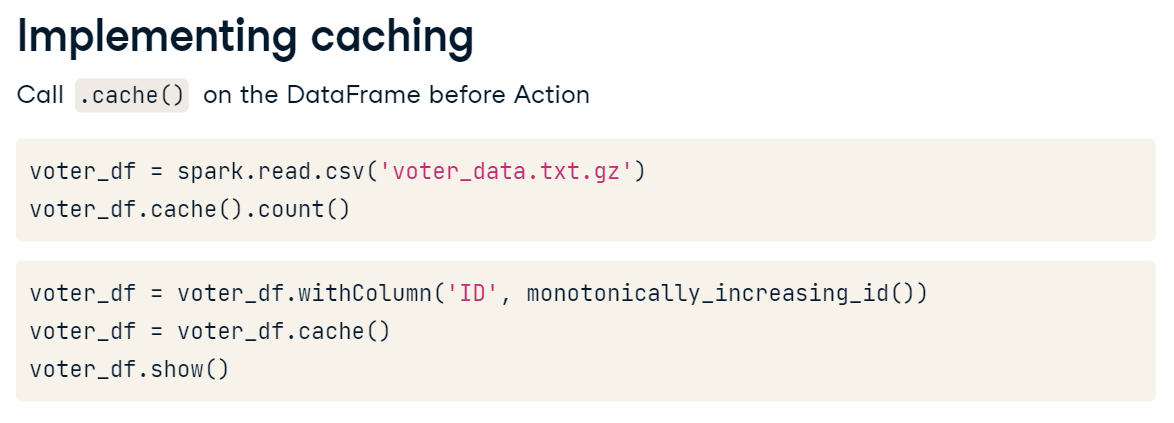

In [6]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/20.png"))

A couple other options are available with caching in Spark. To check if a DataFrame is cached, use the .is_cached boolean property which returns True (as in this case) or False. To un-cache a DataFrame, we call .unpersist() with no arguments. This removes the object from the cache.

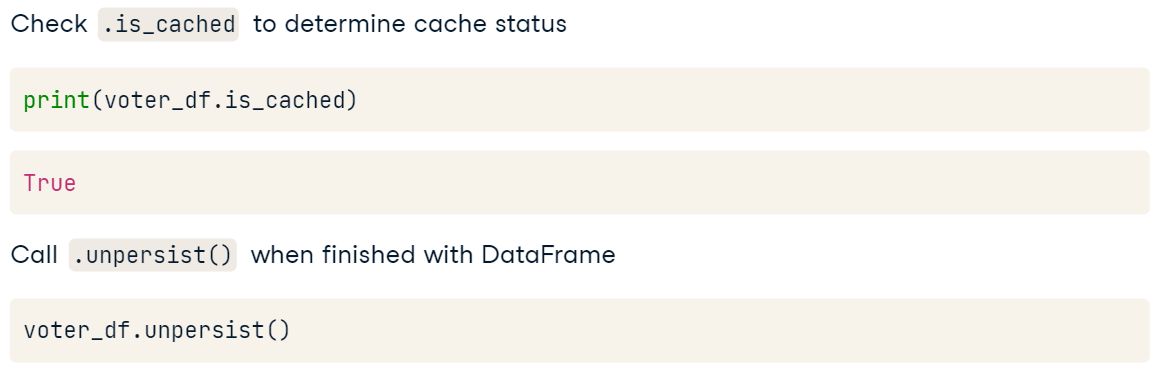

In [8]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/22.png"))

### Ex: Caching a DataFrame

You've been assigned a task that requires running several analysis operations on a DataFrame. You've learned that caching can improve performance when reusing DataFrames and would like to implement it.

You'll be working with a new dataset consisting of airline departure information. It may have repetitive data and will need to be de-duplicated.

The DataFrame departures_df is defined, but no actions have been performed.

In [ ]:
start_time = time.time()

# Add caching to the unique rows in departures_df
departures_df = departures_df.distinct().cache()

# Count the unique rows in departures_df, noting how long the operation takes
print("Counting %d rows took %f seconds" % (departures_df.count(), time.time() - start_time))

# Count the rows again, noting the variance in time of a cached DataFrame
start_time = time.time()
print("Counting %d rows again took %f seconds" % (departures_df.count(), time.time() - start_time))


### Ex: Removing a DataFrame from cache

You've finished the analysis tasks with the departures_df DataFrame, but have some other processing to do. You'd like to remove the DataFrame from the cache to prevent any excess memory usage on your cluster.

The DataFrame departures_df is defined and has already been cached for you.

In [ ]:
# Determine if departures_df is in the cache
print("Is departures_df cached?: %s" % departures_df.is_cached)
print("Removing departures_df from cache")

# Remove departures_df from the cache
departures_df.unpersist()

# Check the cache status again
print("Is departures_df cached?: %s" % departures_df.is_cached)


# Improve Import Performance

We've discussed the benefits of caching when working with Spark DataFrames. Let's look at how to improve the speed when getting data into a DataFrame.

Spark clusters consist of two types of processes - one driver process and as many worker processes as required. The driver handles task assignments and consolidation of the data results from the workers. The workers typically handle the actual transformation / action tasks of a Spark job. Once assigned tasks, they operate fairly independently and report results back to the driver. It is possible to have a single node Spark cluster (this is what we're using for this course) but you'll rarely see this in a production environment. There are different ways to run Spark clusters - the method used depends on your specific environment.

When importing data to Spark DataFrames, it's important to understand how the cluster implements the job. The process varies depending on the type of task, but it's safe to assume that the more import objects available, the better the cluster can divvy up the job. This may not matter on a single node cluster, but with a larger cluster each worker can take part in the import process. In clearer terms, one large file will perform considerably worse than many smaller ones. Depending on the configuration of your cluster, you may not be able to process larger files, but could easily handle the same amount of data split between smaller files. Note you can define a single import statement, even if there are multiple files. You can use any form of standard wildcard symbol when defining the import filename. While less important, if objects are about the same size, the cluster will perform better than having a mix of very large and very small objects.


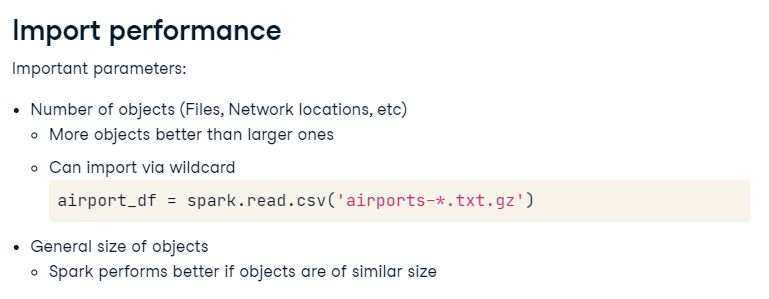

In [4]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/23.png"))

### Schemas

If you remember from chapter one, we discussed the importance of Spark schemas. Well-defined schemas in Spark drastically improve import performance. Without a schema defined, import tasks require reading the data multiple times to infer structure. This is very slow when you have a lot of data. Spark may not define the objects in the data the same as you would. Spark schemas also provide validation on import. This can save steps with data cleaning jobs and improve the overall processing time.

### How to split objects

There are various effective ways to split an object (files mostly) into more smaller objects. The first is to use built-in OS utilities such as split, cut, or awk. An example using split uses the -l argument with the number of lines to have per file (10000 in this case). The -d argument tells split to use numeric suffixes. The last two arguments are the name of the file to be split and the prefix to be used. Assuming 'largefile' has 10M records, we would have files named chunk-0000 through chunk-9999. Another method is to use python (or any other language) to split the objects up as we see fit. Sometimes you may not have the tools available to split a large file. If you're going to be working with a DataFrame often, a simple method is to read in the single file then write it back out as parquet. We've done this in previous examples and it works well for later analysis even if the initial import is slow. It's important to note that if you're hitting limitations due to cluster sizing, try to do as little processing as possible before writing to parquet.

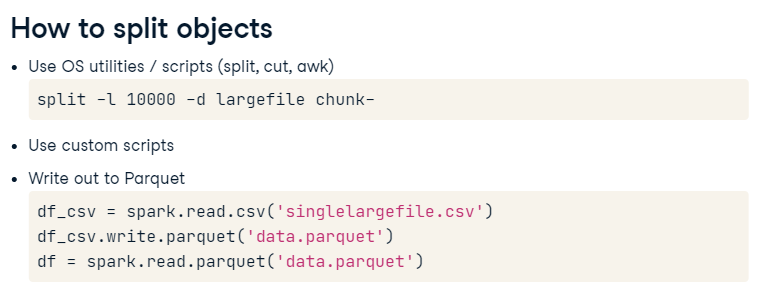

In [6]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/24.png"))

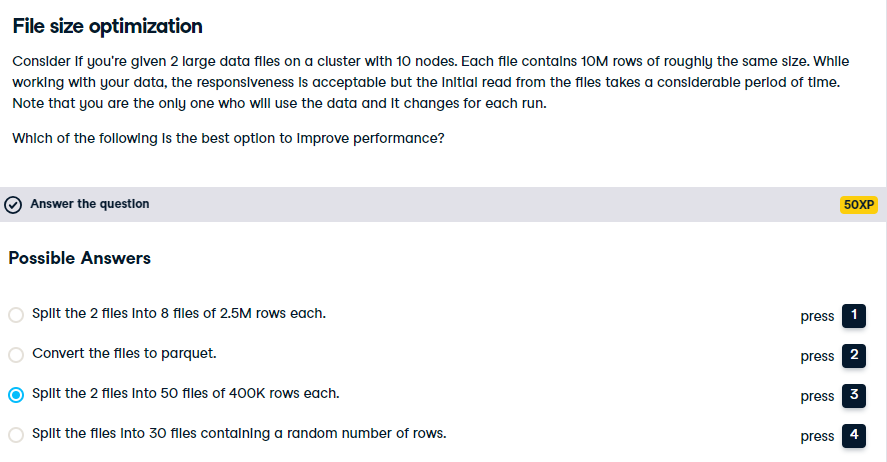

In [7]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/25.png"))

#### Ex. File import performance

You've been given a large set of data to import into a Spark DataFrame. You'd like to test the difference in import speed by splitting up the file.

You have two types of files available: departures_full.txt.gz and departures_xxx.txt.gz where xxx is 000 - 013. The same number of rows is split between each file.

In [ ]:
# Import the full and split files into DataFrames
full_df = spark.read.csv('departures_full.txt.gz')
split_df = spark.read.csv('departures_0*.txt.gz')

# Print the count and run time for each DataFrame
start_time_a = time.time()
print("Total rows in full DataFrame:\t%d" %full_df.count())
print("Time to run: %f" % (time.time() - start_time_a))

start_time_b = time.time()
print("Total rows in split DataFrame:\t%d" %split_df.count())
print("Time to run: %f" % (time.time() - start_time_b))

# Cluster Configurations

We've just finished working with improving import performance in Spark. Let's take a look at cluster configurations.

Spark has many available configuration settings controlling all aspects of the installation. These configurations can be modified to best match the specific needs for the cluster. The configurations are available in the configuration files, via the Spark web interface, and via the run-time code. Our test cluster is only accessible via command shell so we'll use the last option. To read a configuration setting, call spark.conf.get() with the name of the setting as the argument. To write a configuration setting, call spark.conf.set() with the name of the setting and the actual value as the function arguments.

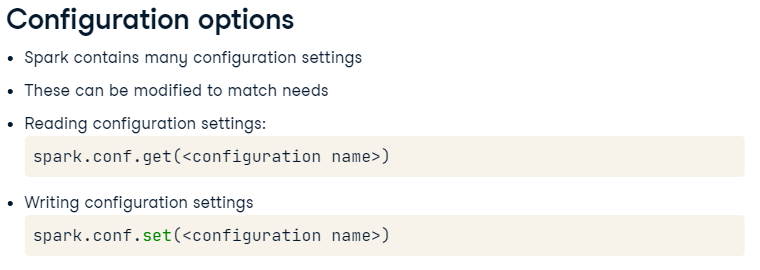

In [3]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/26.png"))

## Cluster Types

Spark deployments can vary depending on the exact needs of the users. One large component of a deployment is the cluster management mechanism. Spark clusters can be: Single node clusters, deploying all components on a single system (physical / VM / container). Standalone clusters, with dedicated machines as the driver and workers. Managed clusters, meaning that the cluster components are handled by a third party cluster manager such as YARN, Mesos, or Kubernetes. In this course, we're using a single node cluster. Your production environment can vary wildly, but we'll discuss standalone clusters as the concepts flow across all management types.

## Driver

If you recall, there is one driver per Spark cluster. The driver is responsible for several things, including the following: Handling task assignment to the various nodes / processes in the cluster. The driver monitors the state of all processes and tasks and handles any task retries. The driver is also responsible for consolidating results from the other processes in the cluster. The driver handles any access to shared data and verifies each worker process has the necessary resources (code, data, etc). Given the importance of the driver, it is often worth increasing the specifications of the node compared to other systems. Doubling the memory compared to other nodes is recommended. This is useful for task monitoring and data consolidation tasks. As with all Spark systems, fast local storage is useful for running Spark in an ideal setup.

## Worker

A Spark worker handles running tasks assigned by the driver and communicates those results back to the driver. Ideally, the worker has a copy of all code, data, and access to the necessary resources required to complete a given task. If any of these are unavailable, the worker must pause to obtain the resources. When sizing a cluster, there are a few recommendations: Depending on the type of task, more worker nodes is often better than larger nodes. This can be especially obvious during import and export operations as there are more machines available to do the work. As with everything in Spark, test various configurations to find the correct balance for your workload. Assuming a cloud environment, 16 worker nodes may complete a job in an hour and cost $50 in resources. An 8 worker configuration might take 1.25 hrs but cost only half as much. Finally, workers can make use of fast local storage (SSD / NVMe) for caching, intermediate files, etc.

## Example: Reading Spark configurations

You've recently configured a cluster via a cloud provider. Your only access is via the command shell or your python code. You'd like to verify some Spark settings to validate the configuration of the cluster.

The spark object is available for use.

- Check the name of the Spark application instance ('spark.app.name').
- Determine the TCP port the driver runs on ('spark.driver.port').
- Determine how many partitions are configured for joins.
- Show the results.

In [ ]:
# Name of the Spark application instance
app_name = spark.conf.get('spark.app.name')

# Driver TCP port
driver_tcp_port = spark.conf.get('spark.driver.port')

# Number of join partitions
num_partitions = spark.conf.get('spark.sql.shuffle.partitions')

# Show the results
print("Name: %s" % app_name)
print("Driver TCP port: %s" % driver_tcp_port)
print("Number of partitions: %s" % num_partitions)


## Writing Spark configurations

Now that you've reviewed some of the Spark configurations on your cluster, you want to modify some of the settings to tune Spark to your needs. You'll import some data to review that your changes have affected the cluster.

The spark configuration is initially set to the default value of 200 partitions.

The spark object is available for use. A file named departures.txt.gz is available for import. An initial DataFrame containing the distinct rows from departures.txt.gz is available as departures_df.

-Store the number of partitions in departures_df in the variable before.

-Change the spark.sql.shuffle.partitions configuration to 500 partitions.

-Recreate the departures_df DataFrame reading the distinct rows from the departures file.

-Print the number of partitions from before and after the configuration change.

In [ ]:
# Store the number of partitions in variable
before = departures_df.rdd.getNumPartitions()

# Configure Spark to use 500 partitions
spark.conf.set('spark.sql.shuffle.partitions',500)

# Recreate the DataFrame using the departures data file
departures_df = spark.read.csv('departures.txt.gz').distinct()

# Print the number of partitions for each instance
print("Partition count before change: %d" % before)
print("Partition count after change: %d" % departures_df.rdd.getNumPartitions())

# Performance improvements

We've discussed Spark clusters and improving import performance. Let's look at how to improve the performance of Spark tasks in general.

## Explaining the Spark execution plan

To understand performance implications of Spark, you must be able to see what it's doing under the hood. The easiest way to do this is to use the .explain() function on a DataFrame. This example is taken from an earlier exercise, simply requesting a single column and running distinct against it. The result is the estimated plan that will be run to generate results from the DataFrame. Don't worry about the specifics of the plan yet, just remember how to view it if needed.

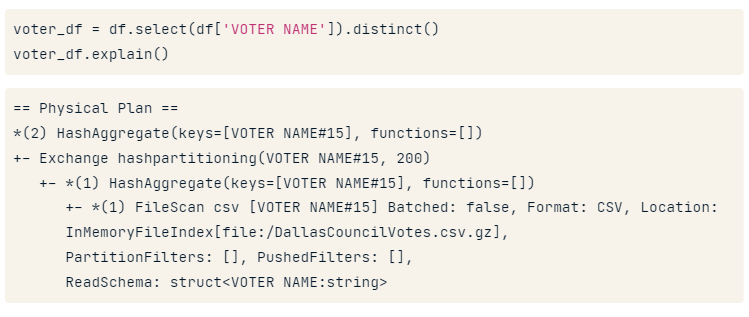

In [4]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/27.png"))

## What is shuffling?

Spark distributes data amongst the various nodes in the cluster. A side effect of this is what is known as shuffling. Shuffling is the moving of data fragments to various workers as required to complete certain tasks. Shuffling is useful and hides overall complexity from the user (the user doesn't have to know which nodes have what data). That being said, it can be slow to complete the necessary transfers, especially if a few nodes require all the data. Shuffling lowers the overall throughput of the cluster as the workers must spend time waiting for the data to transfer. This limits the amount of available workers for the remaining tasks in the system. Shuffling is often a necessary component, but it's helpful to try to minimize it as much as possible.

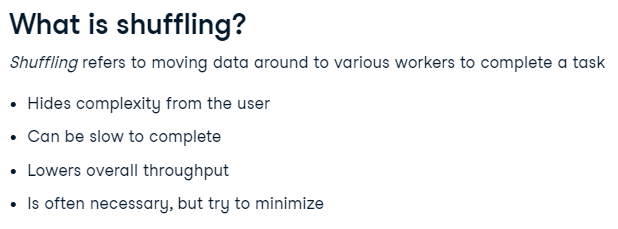

In [5]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/28.png"))

## How to remove shuffling?

It can be tricky to remove shuffling operations entirely but there are a few things that can limit it. The DataFrame .repartition() function takes a single argument, the number of partitions requested. We've used this in an earlier chapter to illustrate the effect of partitions with the monotonically_increasing_id() function. Repartitioning requires a full shuffle of data between nodes & processes and is quite costly. If you need to reduce the number of partitions, use the .coalesce() function instead. It takes a number of partitions smaller than the current one and consolidates the data without requiring a full data shuffle. Note: calling .coalesce() with a larger number of partitions does not actually do anything. The .join() function is a great use of Spark and provides a lot of power. Calling .join() indiscriminately can often cause shuffle operations, leading to increased cluster load & slower processing times. To avoid some of the shuffle operations when joining Spark DataFrames you can use the .broadcast() function. We'll talk about this more in a moment. Finally, an important note about data cleaning operations is remembering to optimize for what matters. The speed of your initial code may be perfectly acceptable and time may be better spent elsewhere.

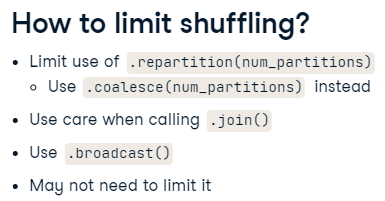

In [7]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/29.png"))

## Broadcasting

Broadcasting in Spark is a method to provide a copy of an object to each worker. When each worker has its own copy of the data, there is less need for communication between nodes. This limits data shuffles and it's more likely a node will fulfill tasks independently. Using broadcasting can drastically speed up .join() operations, especially if one of the DataFrames being joined is much smaller than the other. To implement broadcasting, you must import the broadcast function from pyspark.sql.functions. Once imported, simply call the broadcast function with the name of the DataFrame you wish to broadcast. Note broadcasting can slow operations when using very small DataFrames or if you broadcast the larger DataFrame in a join. Spark will often optimize this for you, but as usual, run tests in your environment for best performance.

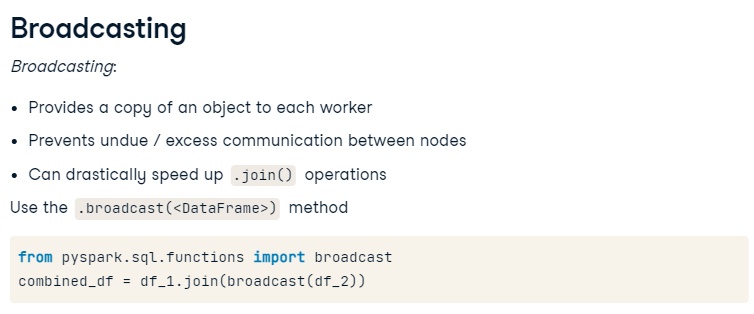

In [8]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/30.png"))

## Normal joins

You've been given two DataFrames to combine into a single useful DataFrame. Your first task is to combine the DataFrames normally and view the execution plan.

The DataFrames flights_df and airports_df are available to you.

- Create a new DataFrame normal_df by joining flights_df with airports_df.

- Determine which type of join is used in the query plan.

In [ ]:
# Join the flights_df and aiports_df DataFrames
normal_df = flights_df.join(airports_df, \
    flights_df["Destination Airport"] == airports_df["IATA"] )

# Show the query plan
normal_df.explain()

## Using broadcasting on Spark joins

Remember that table joins in Spark are split between the cluster workers. If the data is not local, various shuffle operations are required and can have a negative impact on performance. Instead, we're going to use Spark's broadcast operations to give each node a copy of the specified data.

A couple tips:

Broadcast the smaller DataFrame. The larger the DataFrame, the more time required to transfer to the worker nodes.
On small DataFrames, it may be better skip broadcasting and let Spark figure out any optimization on its own.
If you look at the query execution plan, a broadcastHashJoin indicates you've successfully configured broadcasting.
The DataFrames flights_df and airports_df are available to you.

-Import the broadcast() method from pyspark.sql.functions.

-Create a new DataFrame broadcast_df by joining flights_df with airports_df, using the broadcasting.

-Show the query plan and consider differences from the original.

In [ ]:
# Import the broadcast method from pyspark.sql.functions
from pyspark.sql.functions import broadcast

# Join the flights_df and airports_df DataFrames using broadcasting
broadcast_df = flights_df.join(broadcast(airports_df), \
    flights_df["Destination Airport"] == airports_df["IATA"] )

# Show the query plan and compare against the original
broadcast_df.explain()

## Comparing broadcast vs normal joins

You've created two types of joins, normal and broadcasted. Now your manager would like to know what the performance improvement is by using Spark optimizations. If the results are promising, you'll be given more opportunity to tweak the Spark setup as needed.

Your DataFrames normal_df and broadcast_df are available for your use.

-Execute .count() on the normal DataFrame.

-Execute .count() on the broadcasted DataFrame.

-Print the count and duration of the DataFrames noting and differences.

In [ ]:
start_time = time.time()
# Count the number of rows in the normal DataFrame
normal_count = normal_df.count()
normal_duration = time.time() - start_time

start_time = time.time()
# Count the number of rows in the broadcast DataFrame
broadcast_count = broadcast_df.count()
broadcast_duration = time.time() - start_time

# Print the counts and the duration of the tests
print("Normal count:\t\t%d\tduration: %f" % (normal_count, normal_duration))
print("Broadcast count:\t%d\tduration: %f" % (broadcast_count, broadcast_duration))

# Complex Processing and Data Pipelines

## Introduction to Data Pipelines

We've spent most of this course working with individual transformations and actions to clean data in Spark. But data is rarely so simple that a couple transformations or actions can prepare it for real analysis. Let's look now at data pipelines.

## What is a data pipeline?

Data pipelines are simply the set of steps needed to move from an input data source, or sources, and convert it to the desired output. A data pipeline can consist of any number of steps or components, and can span many systems. For our purposes, we’ll be setting up a data pipeline within Spark, but realize that a full production data pipeline will likely communicate with many systems.

## What does a data pipeline look like?

Much like Spark in general, a data pipeline typically consists of inputs, transformations, and the outputs of those steps. In addition, there is often validation and analysis steps before delivery of the data to the next user. An input can be any of the data types we've looked at so far, including CSV, JSON, text, etc. It could be from the local file system, or from web services, APIs, databases, and so on. The basic idea is to read the data into a DataFrame as we've done previously. Once we have the data in a DataFrame, we need to transform it in some fashion. You’ve done the individual steps several times throughout this course - adding columns, filtering rows, performing calculations as needed. In our previous examples, we’ve only done one or two of these steps at a time but a pipeline can consist of as many of these steps as needed so we can format the data into our desired output. After we’ve defined our transformations we need to output the data into a usable form. You’ve already written files out to CSV or Parquet format, but it could include multiple copies with various formats, or instead write the output to a database, a web service, etc. The last two steps vary greatly depending on your needs. 

We'll discuss validation in a later lesson, but the idea is to run some form of testing on the data to verify it is as expected. Analysis is often the final step before handing the data off to the next user. This can include things such as row counts, specific calculations, or pretty much anything that makes it easier for the user to consume the dataset.

## Pipeline details

It's important to note that in Spark, a data pipeline is not a formally defined object, but rather a concept. This is different than if you've used the Pipeline object in Spark.ML. For our purposes, a Spark pipeline is all normal code required to complete a task. In this example, we're doing the various tasks required to define a schema, read a datafile, add an ID, then write out two separate data types. The task could be much more complex, but the concept is usually the same.

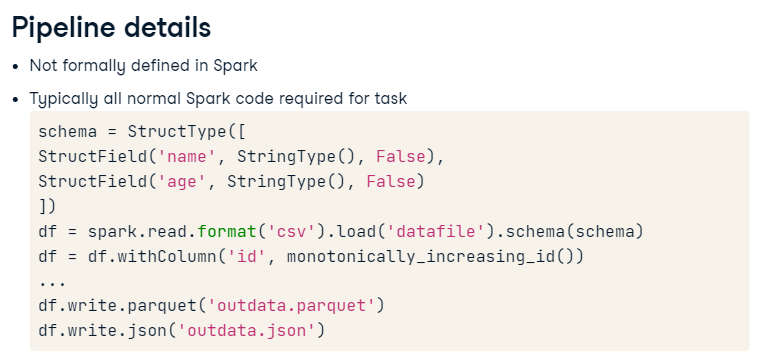

In [9]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/31.png"))

## Quick pipeline

Before you parse some more complex data, your manager would like to see a simple pipeline example including the basic steps. For this example, you'll want to ingest a data file, filter a few rows, add an ID column to it, then write it out as JSON data.

The spark context is defined, along with the pyspark.sql.functions library being aliased as F as is customary.

- Import the file 2015-departures.csv.gz to a DataFrame. Note the header is already defined.
- Filter the DataFrame to contain only flights with a duration over 0 minutes. Use the index of the column, not the column name (remember to use .printSchema() to see the column names / order).
- Add an ID column.
- Write the file out as a JSON document named output.json.

In [ ]:
 # Import the data to a DataFrame
departures_df = spark.read.csv('2015-departures.csv.gz', header=True)

# Remove any duration of 0
departures_df = departures_df.filter(~departures_df[3].contains('0'))

# Add an ID column
departures_df = departures_df.withColumn('id', F.monotonically_increasing_id())

# Write the file out to JSON format
departures_df.write.json('output.json')

### Example 2

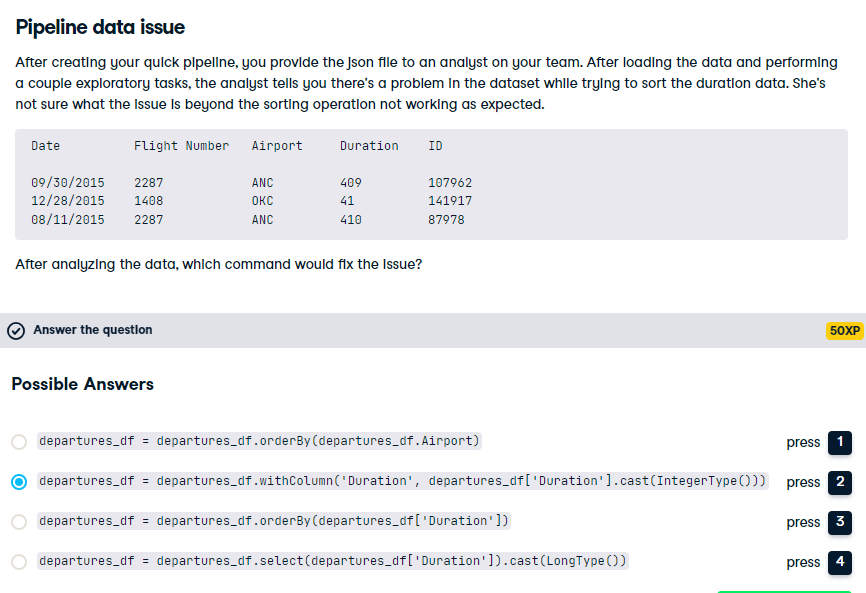

In [10]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/32.png"))

Great job! The original Duration column is a string, so when the analyst tries to sort the data, it's sorted alphabetically, not numerically. Remember that we could have also solved the issue using a defined schema during import to force specific types in the data.

# Data Handling Techniques

We've worked with many aspects of Spark when it comes to data cleaning operations. Let's look at how to use some of the methods we've learned to parse unconventional data.

## What are we trying to parse?

When reading data into Spark, you're rarely given a fully uniform file. Often there is content that needs to be removed or reformatted. Some common issues include: Incorrect data, consisting of empty rows, commented lines, headers, or even rows that don't match the intended schema. Real world data often includes nested structures, including columns that use different delimiters. This could include the primary columns separated via a comma, but including some components separated via a semi-colon. Real data often won't fit into a tabular format, sometimes consisting of a differing number of columns per row. There are various ways to parse data in all of these situations. The way you choose will depend on your specific needs. We are focusing on CSV data for this course, but the general scenarios described apply to other formats as well.

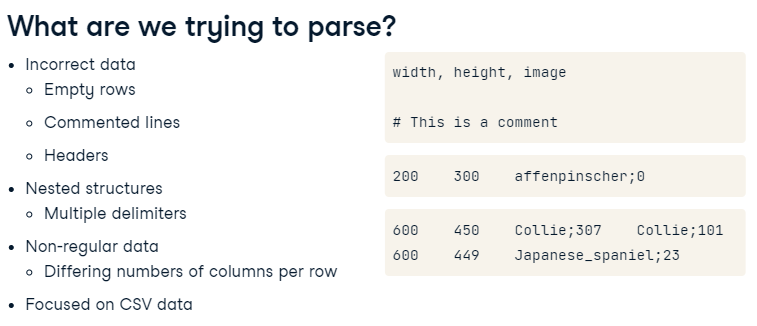

In [11]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/33.png"))

### Stanford ImageNet Annotations

For this chapter we're going to use the Stanford ImageNet annotations which focus on finding and identifying dogs in various ImageNet images. The annotations provide a list of all identified dogs in an image, including when multiple dogs are in the same image. Other metadata is included, including the folder within the ImageNet dataset, the image dimensions, and the bounding box(es) of the dog(s) in the image. In the example rows, we have the folder names, the ImageNet image reference, width, and height. Then there is the image data for the type of dog (or dogs) in each image. 

Each breed "column" consists of the breed name and the bounding box in the image. The first row contains one Newfoundland, but notice that the 2nd row actually has two Bull Mastiffs identified and has an addition "column" defined.

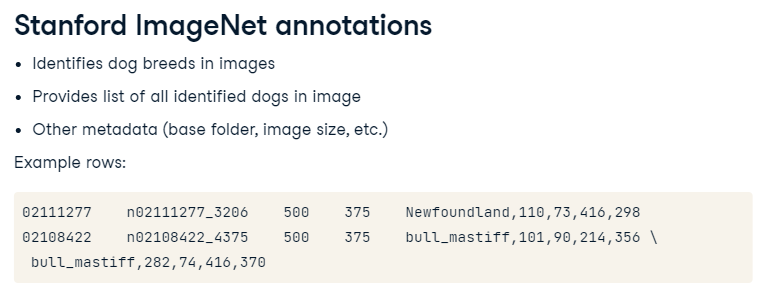

In [12]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/34.png"))

# Removing blank lines, headers & comments

Spark's CSV parser can handle many common data issues via optional parameters. Blank lines are automatically removed (unless specifically instructed otherwise) when using the CSV parsing. Comments can be removed with an optional named argument, comment, and specifying the character that any comment line would be defined by. Note that this handles lines that begin with a specific comment. Parsing more complex comment usage requires more involved procedures. Header rows can be parsed via an optional parameter named header, and set to 'True' or 'False'. If no schema is defined, column names will be initially set as defined by the header. If a schema is defined, the row is not used as data, but the header names are otherwise ignored.

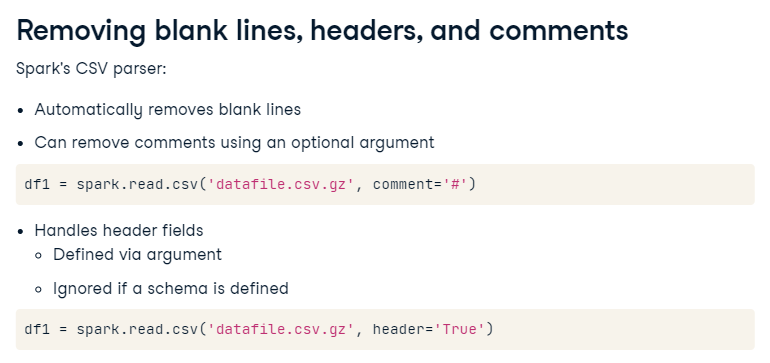

In [13]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/35.png"))

## Automatic Column Creation

When importing CSV data into Spark, it will automatically create DataFrame columns if it can. It will split a row of text from the CSV on a defined separator argument named 'sep'. If sep is not defined, it will default to using a comma. The CSV parser will still succeed in parsing data if the separator character is not within the string. It will store the entire row in a column named _c0 by default. Using this trick allows parsing of nested or complex data. We'll look at this more later on.

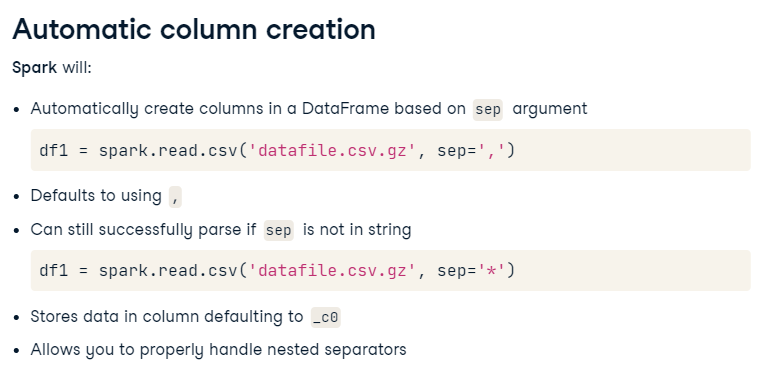

In [14]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/36.png"))

### Example: Removing commented lines

Your boss would like you to perform some complex parsing on a new dataset. The data represents annotation data for the ImageNet dataset, but focusing specifically on dog breeds and identifying them in images. Before any actual analysis can occur, you'll need to clear out several components of invalid / incorrect data. The general schema of the document is unknown so you'd like to import the rows into a single column, allowing for quick analysis.

To start, you need to remove all commented rows in the dataset.
The spark context, and the base CSV file (annotations.csv.gz) are available for you to work with. The col function is also available for use.

In [ ]:
# Import the file to a DataFrame and perform a row count
annotations_df = spark.read.csv('annotations.csv.gz', sep= "|")
full_count = annotations_df.count()

# Count the number of rows beginning with '#'
comment_count = annotations_df.where(col('_c0').startswith('#')).count()

# Import the file to a new DataFrame, without commented rows
no_comments_df = spark.read.csv('annotations.csv.gz', sep = "|", comment='#')

# Count the new DataFrame and verify the difference is as expected
no_comments_count = no_comments_df.count()
print("Full count: %d\nComment count: %d\nRemaining count: %d" % (full_count, comment_count, full_count - comment_count))

### Removing invalid rows

Now that you've successfully removed the commented rows, you have received some information about the general format of the data. There should be at minimum 5 tab separated columns in the DataFrame. Remember that your original DataFrame only has a single column, so you'll need to split the data on the tab (\t) characters.

The DataFrame annotations_df is already available, with the commented rows removed. The spark.sql.functions library is available under the alias F. The initial number of rows available in the DataFrame is stored in the variable initial_count.

In [ ]:
# Split _c0 on the tab character and store the list in a variable
tmp_fields = F.split(annotations_df['_c0'], '\t')

# Create the colcount column on the DataFrame
annotations_df = annotations_df.withColumn('colcount', F.size(tmp_fields))

# Remove any rows containing fewer than 5 fields
annotations_df_filtered = annotations_df.filter(~ (annotations_df["colcount"] < 5))

# Count the number of rows
final_count = annotations_df_filtered.count()
print("Initial count: %d\nFinal count: %d" % (initial_count, final_count))

### Splitting into columns

You've cleaned up your data considerably by removing the invalid rows from the DataFrame. Now you want to perform some further transformations by generating specific meaningful columns based on the DataFrame content.

You have the spark context and the latest version of the annotations_df DataFrame. pyspark.sql.functions is available under the alias F.

In [ ]:
# Split the content of _c0 on the tab character (aka, '\t')
split_cols = F.split(annotations_df['_c0'], '\t')

# Add the columns folder, filename, width, and height
split_df = annotations_df.withColumn('folder', split_cols.getItem(0))
split_df = split_df.withColumn('filename', split_cols.getItem(1))
split_df = split_df.withColumn('width', split_cols.getItem(2))
split_df = split_df.withColumn('height', split_cols.getItem(3))

# Add split_cols as a column
split_df = split_df.withColumn('split_cols', split_cols)

### Further parsing

You've molded this dataset into a significantly different format than it was before, but there are still a few things left to do. You need to prep the column data for use in later analysis and remove a few intermediary columns.

The spark context is available and pyspark.sql.functions is aliased as F. The types from pyspark.sql.types are already imported. The split_df DataFrame is as you last left it. Remember, you can use .printSchema() on a DataFrame in the console area to view the column names and types.

In [ ]:
def retriever(cols, colcount):
  # Return a list of dog data
  return cols[4:colcount]

# Define the method as a UDF
udfRetriever = F.udf(retriever, ArrayType(StringType()))

# Create a new column using your UDF
split_df = split_df.withColumn('dog_list', udfRetriever(split_df.split_cols, split_df.colcount))

# Remove the original column, split_cols, and the colcount
split_df = split_df.drop('_c0').drop('colcount').drop('split_cols')

# Data Validation

Welcome back! Validation is one step of a data pipeline we haven't covered yet, but it is very important in verifying the quality of the data we're delivering. Let's look at how to implement validation steps in a data cleaning pipeline.

In this context, validation is verifying that a dataset complies with an expected format. This can include verifying that the number of rows and columns is as expected. For example, is the row count within 2% of the previous month's row count? Another common test is do the data types match? If not specifically validated with a schema, does the content meet the requirements (only 9 characters or less, etc). Finally, you can validate against more complex rules. This includes verifying that the values of a set of sensor readings are within physically possible quantities.

## Validating via joins

One technique used to validate data in Spark is using joins to verify the content of a DataFrame matches a known set. Validating via a join will compare data against a set of known values. This could be a list of known ids, companies, addresses, etc. Joins make it easy to determine if data is present in a set. This could be only rows that are in one DataFrame, present in both, or present in neither. Joins are also comparatively fast, especially vs validating individual rows against a long list of entries. The simplest example of this is using an inner join of two DataFrames to validate the data. A new DataFrame, parsed_df, is loaded from a given parquet file. The second DataFrame is loaded containing a list of known company names. A new DataFrame is created by joining parsed_df and company_df on the company name. As this is an inner join, only rows from parsed_df with company names that are present in company_df would be included in the new DataFrame (verified_df). This has the effect of automatically filtering out any rows that don't meet the specified criteria. This is done without any kind of Spark filter or comparison code.


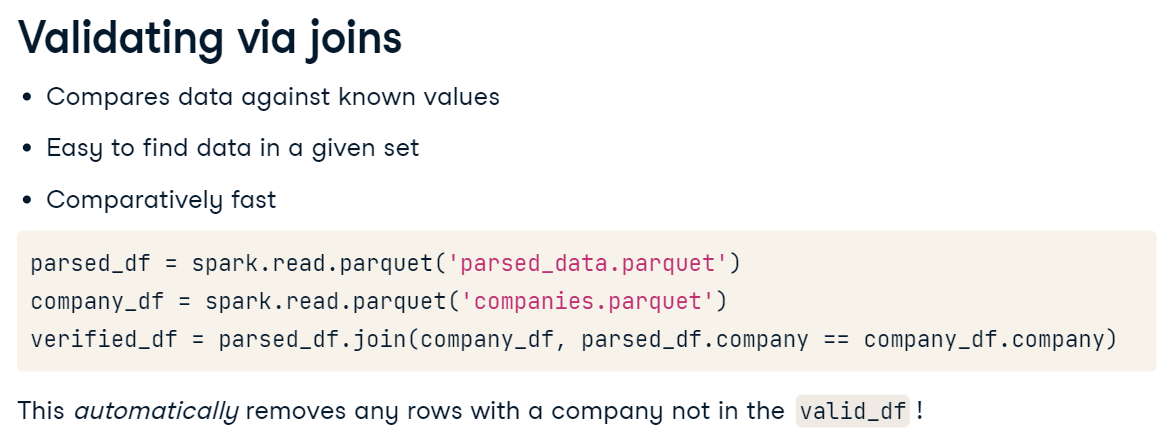

In [3]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/37.png"))

## Complex Rule Validation

Complex rule validation is the idea of using Spark components to validate logic. This may be as simple as using the various Spark calculations to verify the number of columns in an irregular data set. You've done something like this already in the previous lessons. The validation can also be applied against an external source: web service, local files, API calls. These rules are often implemented as a UDF to encapsulate the logic to one place and easily run against the content of a DataFrame.

### Example: Validate rows via join

Another example of filtering data is using joins to remove invalid entries. You'll need to verify the folder names are as expected based on a given DataFrame named valid_folders_df. The DataFrame split_df is as you last left it with a group of split columns.

The spark object is available, and pyspark.sql.functions is imported as F.

In [ ]:
# Rename the column in valid_folders_df
valid_folders_df = valid_folders_df.withColumnRenamed("_c0", "folder")  

# Count the number of rows in split_df
split_count = split_df.count()

# Join the DataFrames
joined_df = split_df.join(F.broadcast(valid_folders_df), "folder")

# Compare the number of rows remaining
joined_count = joined_df.count()
print("Before: %d\nAfter: %d" % (split_count, joined_count))

Nicely done - using joins in this fashion drastically simplifies a validation task if your data permits it. The validation data doesn't necessarily need to be loaded from a file - it could be calculated on the fly, or based on a previous dataset. Optimizing these tasks will improve your overall data cleaning process. Note: There are multiple ways to define the join statement. As both DataFrames have a column with the name 'folder', Spark handles this for us automatically.

### Example: Examining invalid rows

You've successfully filtered out the rows using a join, but sometimes you'd like to examine the data that is invalid. This data can be stored for later processing or for troubleshooting your data sources.

You want to find the difference between two DataFrames and store the invalid rows.

The spark object is defined and pyspark.sql.functions are imported as F. The original DataFrame split_df and the joined DataFrame joined_df are available as they were in their previous states.

In [ ]:
# Determine the row counts for each DataFrame
split_count = split_df.count()
joined_count = joined_df.count()

# Create a DataFrame containing the invalid rows
invalid_df = split_df.join(F.broadcast(joined_df), 'folder', how="left_anti")

# Validate the count of the new DataFrame is as expected
invalid_count = invalid_df.count()
print(" split_df:\t%d\n joined_df:\t%d\n invalid_df: \t%d" % (split_count, joined_count, invalid_count))

# Determine the number of distinct folder rows removed
invalid_folder_count = invalid_df.select('folder').distinct().count()
print("%d distinct invalid folders found" % invalid_folder_count)

Great work! Using different types of joins can produce useful results for the various stages of data cleaning. While there are often multiple ways to accomplish a task, using the various join methods will often finish more quickly and cleanly.

# Final analysis and delivery

We've worked with a lot of Spark components while exploring data cleaning. Let's finish up this data cleaning pipeline with some final analysis calculations.

## Analysis Calculations (UDF)

Analysis calculations are the process of using the columns of data in a DataFrame to compute some useful value using Spark's functionality. We've used UDFs in previous chapters, and this version illustrates calculating an average sale price from a given list of sales. A Python function takes a saleslist argument. For every sale in the saleslist, the function adds the sale entry (from value 2 and 3 in the sale tuple). Once complete, it calculates the actual average per row and returns it. The remaining code is what we've done previously when defining a UDF and using it within a DataFrame.

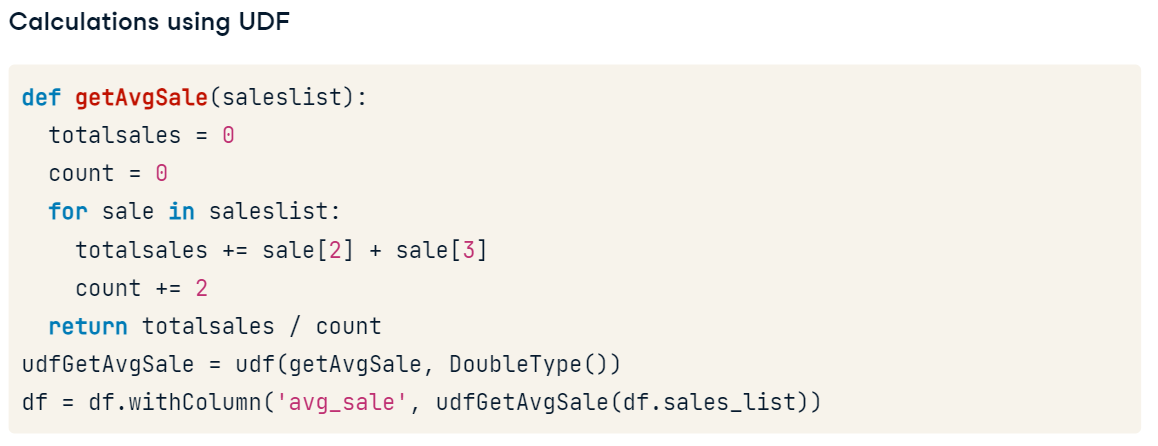

In [4]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/38.png"))

## Inline calculations

Spark UDFs are very powerful and flexible and are sometimes the only way to handle certain types of data. Unfortunately UDFs do come at a performance penalty compared to the built-in Spark functions, especially for certain operations. The solution is to perform calculations inline if possible. Spark columns can be defined using in-line math operations, which can then be optimized for the best performance. In this case, we read in a datafile, then have two examples of adding calculated columns. The first is a simple average computed by using two columns in the DataFrame. The second option computes a square footage by multiplying the values in two columns together to create a third. The final line shows the option of mixing a UDF with an inline calculation. There is often a better way to do this, but it does illustrate Spark does not care about the source of the info as long as it conforms to the expected input format.

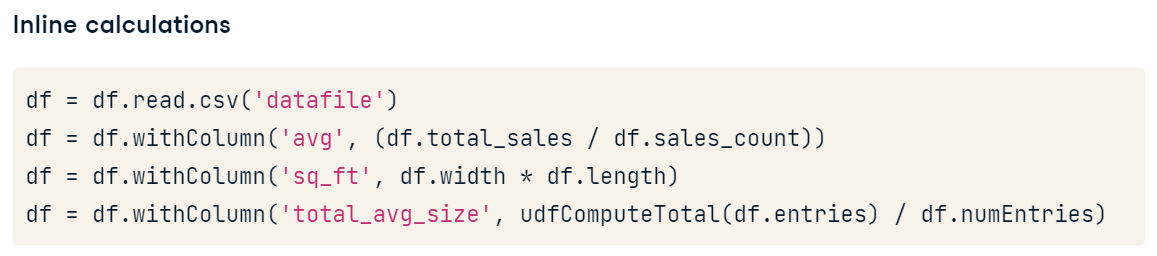

In [5]:
display(Image(filename="C:/Users/yagiz.yaman/Desktop/PySpark/figures/39.png"))

### Example: Dog parsing

You've done a considerable amount of cleanup on the initial dataset, but now need to analyze the data a bit deeper. There are several questions that have now come up about the type of dogs seen in an image and some details regarding the images. You realize that to answer these questions, you need to process the data into a specific type. Before you can use it, you'll need to create a schema / type to represent the dog details.

The joined_df DataFrame is as you last defined it, and the pyspark.sql.types have all been imported.

- Select the column representing the dog details from the DataFrame and show the first 10 un-truncated rows.

- Create a new schema as you've done before, using breed, start_x, start_y, end_x, and end_y as the names. Make sure to specify the proper data types for each field in the schema (any number value is an integer).

In [ ]:
# Select the dog details and show 10 untruncated rows
print(joined_df.select('dog_list').show(10, truncate=False))

# Define a schema type for the details in the dog list
DogType = StructType([
    StructField("breed", StringType(), False),
    StructField("start_x", IntegerType(), False),
    StructField("start_y", IntegerType(), False),
    StructField("end_x", IntegerType(), False),
    StructField("end_y", IntegerType(), False)
])

Nicely done - you'll use this schema soon to determine some details about the dogs in the data. As you've just seen, schemas can be used for importing data, but they can also be used to simplify accessing information within pre-parsed data. If you're wondering why we didn't just define a full schema for the import, the Spark CSV parser is not capable of using complex schema types using lists.

### Per image count

Your next task in building a data pipeline for this dataset is to create a few analysis oriented columns. You've been asked to calculate the number of dogs found in each image based on your dog_list column created earlier. You have also created the DogType which will allow better parsing of the data within some of the data columns.

The joined_df is available as you last defined it, and the DogType StructType is defined. pyspark.sql.functions is available under the F alias.

- Create a Python function to split each entry in dog_list to its appropriate parts. Make sure to convert any strings into the appropriate types or the DogType will not parse correctly.

- Create a UDF using the above function.

- Use the UDF to create a new column called dogs. Drop the previous column in the same command.

- Show the number of dogs in the new column for the first 10 rows.

In [ ]:
# Create a function to return the number and type of dogs as a tuple
def dogParse(doglist):
  dogs = []
  for dog in doglist:
    (breed, start_x, start_y, end_x, end_y) = dog.split(',')
    dogs.append((breed, int(start_x), int(start_y), int(end_x), int(end_y)))
  return dogs

# Create a UDF
udfDogParse = F.udf(dogParse, ArrayType(DogType))

# Use the UDF to list of dogs and drop the old column
joined_df = joined_df.withColumn('dogs', udfDogParse('dog_list')).drop('dog_list')

# Show the number of dogs in the first 10 rows
joined_df.select(F.size('dogs')).show(10)

Fantastic work! It can be tricky handling nested data, but using UDF and normal Python functions will often make better sense of the data.

### Percentage dog pixels

The final task for parsing the dog annotation data is to determine the percentage of pixels in each image that represents a dog (or dogs). You'll need to use the various techniques you've learned in this course to help calculate this information and add it as columns for later analysis.

To calculate the percentage of pixels, first calculate the total number of pixels representing each dog then sum them for the image. You can calculate the bounding box with the formula:

(Xend - Xstart) * (Yend - Ystart)

NOTE: You can ignore the possibility of overlapping bounding boxes in this instance.

For the percentage, calculate the total number of "dog" pixels divided by the total size of the image, multiplied by 100.
The joined_df DataFrame is as you last used it. pyspark.sql.functions is aliased to F.

- Define a Python function to take a list of tuples (the dog objects) and calculate the total number of "dog" pixels per image.

- Create a UDF of the function and use it to create a new column called 'dog_pixels' on the DataFrame.

- Create another column, 'dog_percent', representing the percentage of 'dog_pixels' in the image. Make sure this is between 0-100%. Use the string name of the column alone (ie, "columnname" rather than df.columnname).

- Show the first 10 rows with more than 60% 'dog_pixels' in the image. Use a SQL style string for this (ie, 'columnname > ____').

In [ ]:
# Define a UDF to determine the number of pixels per image
def dogPixelCount(doglist):
  totalpixels = 0
  for dog in doglist:
    totalpixels += (dog[3] - dog[1]) * (dog[4] - dog[2])
  return totalpixels

# Define a UDF for the pixel count
udfDogPixelCount = F.udf(dogPixelCount, IntegerType())
joined_df = joined_df.withColumn('dog_pixels', udfDogPixelCount('dogs'))

# Create a column representing the percentage of pixels
joined_df = joined_df.withColumn('dog_percent', (joined_df.dog_pixels / (joined_df.width * joined_df.height)) * 100)

# Show the first 10 annotations with more than 60% dog
joined_df.where('dog_percent > 60').show(10)

Congratulations! You've now used numerous techniques in Spark to perform the various steps of a data pipeline and answer some meaningful questions about the dataset.

To continue your journey with using Apache Spark, there are a few areas I'd advise you to focus on: Reading the Spark documentation is a great way to add to your knowledge and fill in gaps of understanding. Spark is constantly changing and often adds new features without a lot of fanfare. Seasoned Spark developers often find new techniques that removes a lot of complexity from existing code. Spark works on many platforms regardless of size, but it really shines when using it on multi-node clusters with a lot of RAM. You'll be surprised how quickly Spark processes data when given the resources to function as designed. I've personally processed multi-billion row datasets in a few hours on a relatively modest cluster. Finally, I'd suggest working with as many different datasets as you can find. Different types of data require different techniques in Spark and each has challenges when trying to process data in an efficient way. The datasets available within the various courses here on DataCamp are a great place to start.